In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

In [2]:
# Workspace and Executibles
binary = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6"  # location on MY computer of the compiled modflow program
workarea = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/example_2" # location on MY computer to store files this example (directory must already exist)

# Set Simulation Name
name = "example02_obleo"

##### FLOPY Build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name=binary, version="mf6", sim_ws=workarea
)

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Set Time Structure
Time_Units="YEARS"

##### FLOPY Build time framework ##########
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units=Time_Units, nper=1, perioddata=[(1.0, 1, 1.0)]
)

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html

##### FLOPY Build IMS framework ###########
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Set Model Name (using same base name as the simulation)
model_nam_file = "{}.nam".format(name)

##### FLOPY Build Model Name framework ####
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:

# Define The Grid
Nlay = 1 #number layers
Nrow = 11 #number rows
Ncol = 11 #number columns
# Define distances and elevations
delrow = 1000 # cell size along columns (how tall is a row)
delcol = 1000 # cell size along row (how wide is a column)
topelev = 100.0 # elevation of top of aquifer
thick = 1000.0 #aquifer thickness

bot = [topelev-thick] # bot is a list with Nlay entries
#print(bot)


##### FLOPY Build Model Grid framework #####
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=Nlay,nrow=Nrow,ncol=Ncol,delr=delrow,delc=delcol,top=topelev,botm=bot,
)


/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Define initial conditions
h1 = 0.0 # 
start = h1 * np.ones((Nlay, Nrow, Ncol)) # start heads are h1 everywhere

##### FLOPY Build Initial Conditions framework ###
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Define hydraulic conductivity arrays
K = 3650.0
k = K * np.ones((Nlay, Nrow, Ncol)) # Hydraulic conductivity is K everywhere
# Use above to build layer-by-layer spatial varying K
# need to read: to deal with Kx!=Ky


##### FLOPY Build BCF framework ######
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True) 
# setting icelltype > 0 is unconfined 
# https://flopy.readthedocs.io/en/3.3.5/source/flopy.mf6.modflow.mfgwfnpf.html?highlight=icelltype#flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf.icelltype

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Define constant head boundary conditions
chd_rec = []
#h2 = 90 # Just a different value 
#chd_rec.append(((0, 5, 5), h2))
# L,R,T,B constant head boundaries
for layer in range(0, Nlay):
    for row in range(0, Nrow):
        chd_rec.append(((layer, row, 0), h1))  #left column held at h1
        chd_rec.append(((layer, row, Ncol-1), h1)) #right column held at h1
#    for col in range(1,Ncol-1):
#        chd_rec.append(((layer, 0, col), h1)) # top row held at h1
#        chd_rec.append(((layer, Nrow-1 , col), h1)) # bottom row held at h1

        
##### FLOPY Build CHD framework #####          
chd = flopy.mf6.ModflowGwfchd(gwf,maxbound=len(chd_rec),stress_period_data=chd_rec,save_flows=True,
)

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Define wellfields
wel_rec = []
# wel_rec.append((0, 5, 5, -0e6)) # 0 Mm3/yr - use to examine recharge only
wel_rec.append((0, 5, 5, -2114e6)) # 2,114 Mm3/yr

##### FLOPY Build Wellfields framework #####  
wel = flopy.mf6.ModflowGwfwel(gwf,maxbound=len(wel_rec),stress_period_data=wel_rec,
)

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Define recharge
rech_val = 0.25 #  rate as depth/year
rech_rec = rech_val * np.ones((1, Nrow, Ncol)) # set recharge top layer only

rch = flopy.mf6.ModflowGwfrcha(gwf, maxbound=len(rech_rec),recharge=rech_rec)

#rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rech_val) # default entry format

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# something to do with stress periods
iper = 0
ra = chd.stress_period_data.get_data(key=iper)


/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

##### FLOPY Build OC framework
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# Write files to the directory
sim.write_simulation()

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model example02_obleo...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
    writing package wel_0...
    writing package rcha_0...
    writing package oc...


In [15]:
# Attempt to run MODFLOW this model
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FloPy is using the following executable to run the model: /home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

         MODFLOW 6 compiled Apr 16 2023 18:27:14 with GCC version 9.4.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Als

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


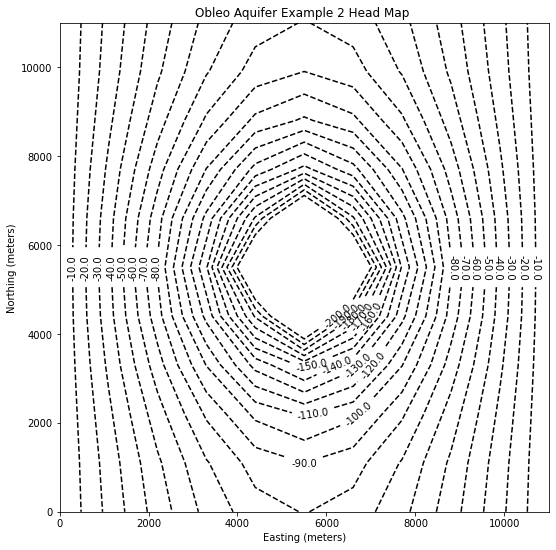

In [16]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 0))
x =  np.linspace(0, delrow*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -200., 100.0
contour_intervals = np.arange(-200., 0., 10.)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Obleo Aquifer Example 2 Head Map ")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


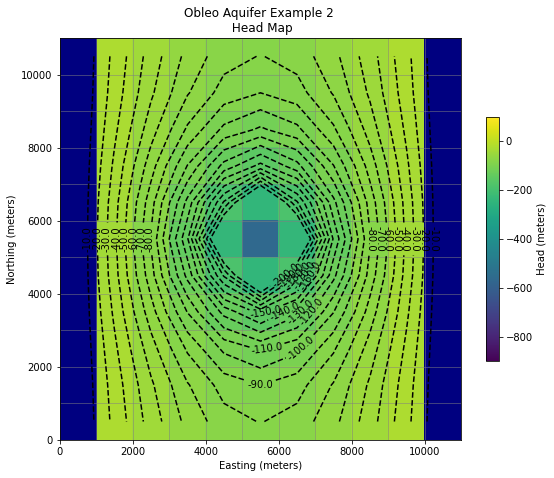

In [17]:
# ### Use the FloPy `PlotMapView()` capabilities for MODFLOW 6

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Obleo Aquifer Example 2 \n Head Map")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=-900, vmax=100)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")

cb = plt.colorbar(pa, shrink=0.5, ax=ax)
cb.set_label(' Head (meters) ', rotation=90)

In [18]:
print("Minimum allowed is -650.0 meters")
print("Pumping at P-1 is:",wel_rec[0][3]/1e6," Mm^3/yr")
print("Minimum Head is:",round(h[0].min(),1)," meters")
if h[0].min() < -650.0:
    print("Computed head is below allowed value - reduce pumpage and rerun simulation")

Minimum allowed is -650.0 meters
Pumping at P-1 is: -2114.0  Mm^3/yr
Minimum Head is: -563.4  meters


/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

/opt/jupyterhub/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#dir(flopy.mf6)

In [21]:
# Workspace and Executibles
binary = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6"  # location on MY DEVELOPMENT computer of the compiled modflow program
workarea = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/example_3" # location on MY DEVELOPMENT computer to store files this example (directory must already exist)

# Set Simulation Name
name = "example_3"
#modelname=name

##### FLOPY Build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name=binary, version="mf6", sim_ws=workarea
)

In [22]:
# Set Time Structure
Time_Units="YEARS"

# Multiple stress periods
nper = 3 # how many periods
perlen = [1.0, 100.0, 100.0] # how long each one
nstp = [1, 100, 100] # how many steps in each
steady = [True, False, False] # which ones are steady

perioddata = [(1.0,1,1),(30.0,30,1),(30.0,30,1)]

##### FLOPY Build time framework ##########
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units=Time_Units, nper=3, perioddata=perioddata,
)

In [23]:
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html

##### FLOPY Build IMS framework ###########
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

In [24]:
# Set Model Name (using same base name as the simulation)
model_nam_file = "{}.nam".format(name)

##### FLOPY Build Model Name framework ####
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

In [25]:

# Define The Grid
Nlay = 1 #number layers
Nrow = 11 #number rows
Ncol = 11 #number columns
# Define distances and elevations
delrow = 1000 # cell size along columns (how tall is a row)
delcol = 1000 # cell size along row (how wide is a column)
topelev = 100.0 # elevation of top of aquifer
thick = 1000.0 #aquifer thickness

bot = [topelev-thick] # bot is a list with Nlay entries
#print(bot)


##### FLOPY Build Model Grid framework #####
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=Nlay,nrow=Nrow,ncol=Ncol,delr=delrow,delc=delcol,top=topelev,botm=bot,
)


In [26]:
# Define initial conditions
h1 = 0.0 # 
start = h1 * np.ones((Nlay, Nrow, Ncol)) # start heads are h1 everywhere

##### FLOPY Build Initial Conditions framework ###
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

In [27]:
# Define hydraulic conductivity arrays
K = 3650.0
k = K * np.ones((Nlay, Nrow, Ncol)) # Hydraulic conductivity is K everywhere
# Use above to build layer-by-layer spatial varying K
# need to read: to deal with Kx!=Ky

##### FLOPY Build BCF framework ######
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True) 
# setting icelltype > 0 is unconfined 
# https://flopy.readthedocs.io/en/3.3.5/source/flopy.mf6.modflow.mfgwfnpf.html?highlight=icelltype#flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf.icelltype

In [28]:
# Define the storativity arrays
Sy = 0.25 # specific yield
Ss = 2.5e-4 # specific storage

sto = flopy.mf6.ModflowGwfsto(gwf, sy=Sy)

In [29]:
# Define constant head boundary conditions - these need to be supplied for each stress period
chd_rec = []
#h2 = 90 # Just a different value 
#chd_rec.append(((0, 5, 5), h2))
# L,R,T,B constant head boundaries
for layer in range(0, Nlay):
    for row in range(0, Nrow):
        chd_rec.append(((layer, row, 0), h1))  #left column held at h1
        chd_rec.append(((layer, row, Ncol-1), h1)) #right column held at h1
#    for col in range(1,Ncol-1):
#        chd_rec.append(((layer, 0, col), h1)) # top row held at h1
#        chd_rec.append(((layer, Nrow-1 , col), h1)) # bottom row held at h1

stress_period_data = {0: chd_rec, 1: chd_rec, 2: chd_rec} # dictionary same BC each stress period
        
##### FLOPY Build CHD framework #####          
chd = flopy.mf6.ModflowGwfchd(gwf,maxbound=len(chd_rec),stress_period_data=stress_period_data,save_flows=True,
)

In [30]:
# Define wellfields
#wel_rec = []
# wel_rec.append((0, 5, 5, -0e6)) # 0 Mm3/yr - use to examine recharge only
#wel_rec.append((0, 5, 5, -2114e6)) # 2,114 Mm3/yr
# Multiple Stress Periods
pumping_rate = -1000e6
wel_sp1 = [[0, 5, 5, 0.0]]
wel_sp2 = [[0, 5, 5, 1*pumping_rate]]
wel_sp3 = [[0, 5, 5, 2.115*pumping_rate]]
stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}
#wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)



##### FLOPY Build Wellfields framework #####  
wel = flopy.mf6.ModflowGwfwel(gwf,maxbound=1,stress_period_data=stress_period_data,)

In [31]:
# Define recharge
rech_val = 0.25 #  rate as depth/year
rech_rec = rech_val * np.ones((1, Nrow, Ncol)) # set recharge top layer only

rec_sp1 = rech_rec
rec_sp2 = rech_rec
rec_sp3 = rech_rec

stress_period_data = {0: rec_sp1, 1: rec_sp2, 2: rec_sp3}

rch = flopy.mf6.ModflowGwfrcha(gwf, maxbound=len(rech_rec),recharge=stress_period_data,)

#rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rech_val) # default entry format

In [32]:
# something to do with stress periods
iper = 0
ra = chd.stress_period_data.get_data(key=iper)


In [33]:
# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

##### FLOPY Build OC framework
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [34]:
# Write files to the directory
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model example_3...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package chd_0...
    writing package wel_0...
    writing package rcha_0...
    writing package oc...


In [35]:
# Attempt to run MODFLOW this model
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: /home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

         MODFLOW 6 compiled Apr 16 2023 18:27:14 with GCC version 9.4.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Als

0.9213486227356542


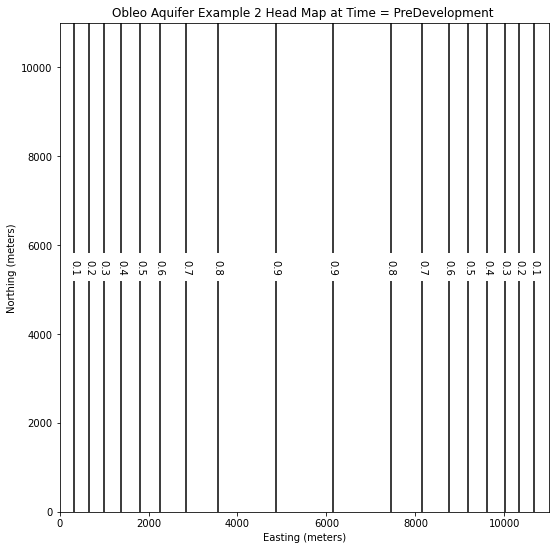

In [36]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 0))
print(h[0].max())
x =  np.linspace(0, delrow*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -200., 100.0
contour_intervals = np.arange(-10., 1.0, 0.1)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Obleo Aquifer Example 2 Head Map at Time = PreDevelopment ")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

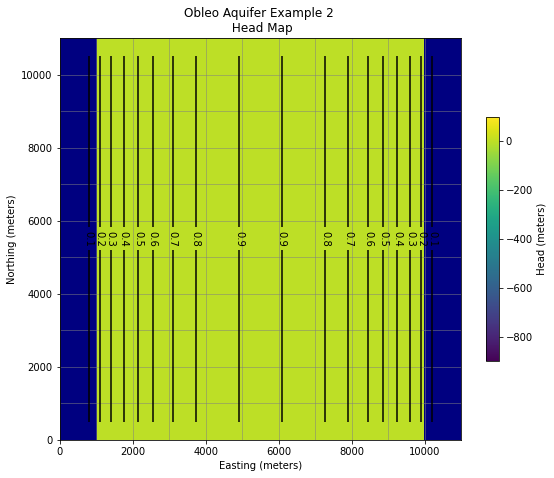

In [37]:
# ### Use the FloPy `PlotMapView()` capabilities for MODFLOW 6

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Obleo Aquifer Example 2 \n Head Map")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=-900, vmax=100)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")

cb = plt.colorbar(pa, shrink=0.5, ax=ax)
cb.set_label(' Head (meters) ', rotation=90)

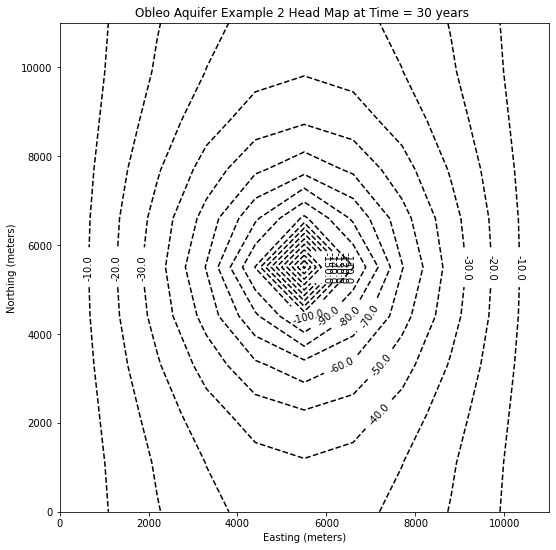

In [38]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 1))
#print(h[0].min())
x =  np.linspace(0, delrow*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -200., 100.0
contour_intervals = np.arange(-200., 1.0, 10)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Obleo Aquifer Example 2 Head Map at Time = 30 years ")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

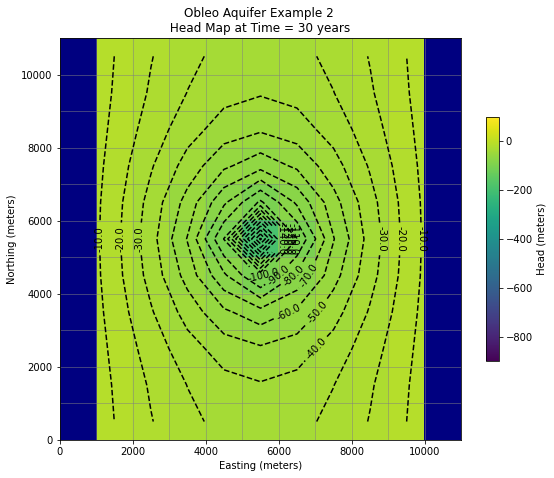

In [39]:
# ### Use the FloPy `PlotMapView()` capabilities for MODFLOW 6

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Obleo Aquifer Example 2 \n Head Map at Time = 30 years ")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=-900, vmax=100)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")

cb = plt.colorbar(pa, shrink=0.5, ax=ax)
cb.set_label(' Head (meters) ', rotation=90)

0.0


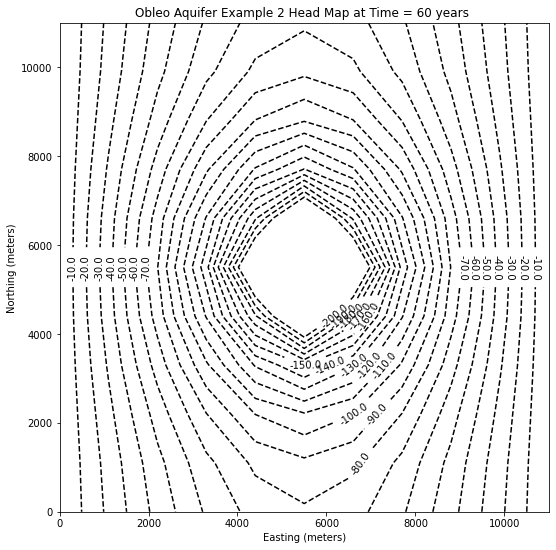

In [40]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(0, 2))
print(h[0].max())
x =  np.linspace(0, delrow*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -200., 100.0
contour_intervals = np.arange(-200., 1.0, 10)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Obleo Aquifer Example 2 Head Map at Time = 60 years ")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

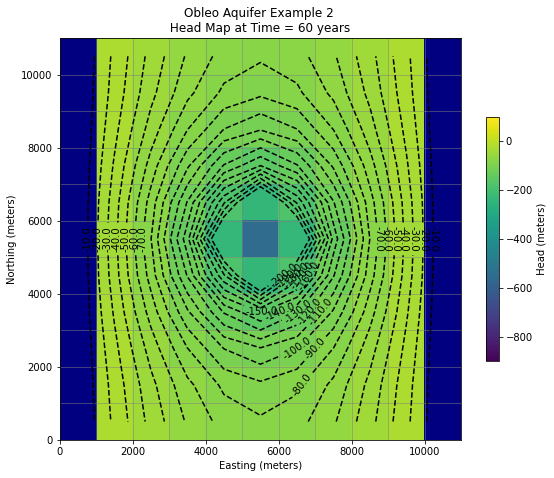

In [41]:
# ### Use the FloPy `PlotMapView()` capabilities for MODFLOW 6

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.set_title("Obleo Aquifer Example 2 \n Head Map at Time = 60 years ")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
pa = modelmap.plot_array(h, vmin=-900, vmax=100)
quadmesh = modelmap.plot_bc("CHD")
linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
contours = modelmap.contour_array(
    h,
    levels=contour_intervals,
    colors="black",
)
ax.clabel(contours, fmt="%2.1f")

cb = plt.colorbar(pa, shrink=0.5, ax=ax)
cb.set_label(' Head (meters) ', rotation=90)

In [42]:
print("Minimum allowed is -650.0 meters")
#print("Pumping at P-1 is:",wel_rec[0][3]/1e6," Mm^3/yr")
print("Minimum Head is:",round(h[0].min(),1)," meters")
if h[0].min() < -650.0:
    print("Computed head is below allowed value - reduce pumpage and rerun simulation")

Minimum allowed is -650.0 meters
Minimum Head is: -552.3  meters


In [43]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

In [44]:
#dir(flopy.mf6)


In [45]:
# Workspace and Executibles
binary = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6"  # location on MY computer of the compiled modflow program
workarea = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/project_1" # location on MY computer to store files this example (directory must already exist)

# Set Simulation Name
name = "project_1"
#modelname=name

##### FLOPY Build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name=name, exe_name=binary, version="mf6", sim_ws=workarea
)

In [46]:
# Set Time Structure
Time_Units="YEARS"

# Multiple stress periods
nper = 4 # how many periods
# perlen = how long each one in problem time units
# nstp =  how many steps in each stress period
# tsmult = time step multiplier
# perioddata = [(perlen,nstp,tsmult),(perlen,nstp,tsmult),(perlen,nstp,tsmult) ... repeat for each stress period]

perioddata = [(30.0,30,1),(30.0,30,1),(30.0,30,1),(30.0,30,1)]

##### FLOPY Build time framework ##########
tdis = flopy.mf6.ModflowTdis(
    sim, pname="tdis", time_units=Time_Units, nper=nper, perioddata=perioddata,
)

In [47]:
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html

##### FLOPY Build IMS framework ###########
ims = flopy.mf6.ModflowIms(sim, pname="ims", complexity="SIMPLE")

In [48]:
# Set Model Name (using same base name as the simulation)
model_nam_file = "{}.nam".format(name)

##### FLOPY Build Model Name framework ####
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, model_nam_file=model_nam_file)

In [49]:
# Define The Grid
Nlay = 5 #number layers
Nrow = 24 #number rows
Ncol = 11 #number columns
# Define distances and elevations
delrow = 1000 # cell size along columns (how tall is a row)
delcol = 1000 # cell size along row (how wide is a column)
topelev = 180.0 # elevation of top of aquifer
thick = 175.0 #aquifer thickness

#bot = [topelev-thick] # bot is a list with Nlay entries
bot = np.array([125,65,60,25,0])
#print(bot)


##### FLOPY Build Model Grid framework #####
dis = flopy.mf6.ModflowGwfdis(gwf,nlay=Nlay,nrow=Nrow,ncol=Ncol,delr=delrow,delc=delcol,top=topelev,botm=bot,
)


In [50]:
# Define initial conditions
h1 = 151.0 # 
start = h1 * np.ones((Nlay, Nrow, Ncol)) # start heads are h1 everywhere

##### FLOPY Build Initial Conditions framework ###
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

In [51]:
# Define hydraulic conductivity arrays
K1 = 2*3650.0
K2 = 2*3650.0
K3 = 0.01*3650.0
K4 = 2*3650.0
K5 = 4*3650
k = np.ones((Nlay, Nrow, Ncol)) # populate k with ones
#print(k) # check structure
k[0] = K1*np.ones((1, Nrow, Ncol))
k[1] = K2*np.ones((1, Nrow, Ncol))
k[2] = K3*np.ones((1, Nrow, Ncol)) # modify for spatial varying K this layer
for irow in range(18,Nrow):
    k[2][irow] = K2
k[3] = K4*np.ones((1, Nrow, Ncol))
k[4] = K5*np.ones((1, Nrow, Ncol))
#print(k[2]) # check structure
# Use above to build layer-by-layer spatial varying K
# need to read: to deal with Kx!=Ky

##### FLOPY Build BCF framework ######
npf = flopy.mf6.ModflowGwfnpf(gwf, icelltype=1, k=k, save_flows=True) 
# setting icelltype > 0 is unconfined 
# https://flopy.readthedocs.io/en/3.3.5/source/flopy.mf6.modflow.mfgwfnpf.html?highlight=icelltype#flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf.icelltype

In [52]:
# Define the storativity arrays
Sy = 0.25 # specific yield
Ss = 2.5e-4 # specific storage

sto = flopy.mf6.ModflowGwfsto(gwf, sy=Sy)

In [53]:
# Define constant head boundary conditions - these need to be supplied for each stress period
chd_rec = []
hriv = 151 # river as a boundary
for col in range(0,Ncol):
    chd_rec.append(((0, 6 , col), hriv)) # river as a boundary
#chd_rec.append(((0, 5, 5), h2))
# L,R,T,B constant head boundaries
#for layer in range(0, Nlay):
#    for row in range(0, Nrow):
#        chd_rec.append(((layer, row, 0), h1))  #left column held at h1
#        chd_rec.append(((layer, row, Ncol-1), h1)) #right column held at h1
#    for col in range(1,Ncol-1):
#        chd_rec.append(((layer, 0, col), h1)) # top row held at h1
#        chd_rec.append(((layer, Nrow-1 , col), h1)) # bottom row held at h1

stress_period_data = {0: chd_rec, 1: chd_rec, 2: chd_rec, 3: chd_rec} # dictionary same BC each stress period
        
##### FLOPY Build CHD framework #####          
chd = flopy.mf6.ModflowGwfchd(gwf,maxbound=len(chd_rec),stress_period_data=stress_period_data,save_flows=True,
)

In [54]:
# Define wellfields
#wel_rec = []
# wel_rec.append((0, 5, 5, -0e6)) # 0 Mm3/yr - use to examine recharge only
#wel_rec.append((0, 5, 5, -2114e6)) # 2,114 Mm3/yr
# Multiple Stress Periods


wel_sp1 = []
wel_sp1.append((0, 21, 5, -0.01)) #wellfieldA-upper
wel_sp1.append((1, 21, 5, -0.01)) #wellfieldA-lower
wel_sp1.append((3, 14, 6, -0.01)) #wellfieldB-upper
wel_sp1.append((4, 14, 6, -0.01)) #wellfieldB-lower
wel_sp1.append((3, 4, 6, -0.01)) #wellfieldC-upper
wel_sp1.append((4, 4, 6, -0.01)) #wellfieldC-lower

wel_sp2 = []
wel_sp2.append((0, 21, 5, -5.0e6)) #wellfieldA-upper
wel_sp2.append((1, 21, 5, -5.0e6)) #wellfieldA-lower
wel_sp2.append((3, 14, 6, -0.1)) #wellfieldB-upper
wel_sp2.append((4, 14, 6, -0.1)) #wellfieldB-lower
wel_sp2.append((3, 4, 6, -0.1)) #wellfieldC-upper
wel_sp2.append((4, 4, 6, -0.1)) #wellfieldC-lower

wel_sp3 = []
wel_sp3.append((0, 21, 5, -5.0e6)) #wellfieldA-upper
wel_sp3.append((1, 21, 5, -5.0e6)) #wellfieldA-lower
wel_sp3.append((3, 14, 6, -8.0e6)) #wellfieldB-upper
wel_sp3.append((4, 14, 6, -8.0e6)) #wellfieldB-lower
wel_sp3.append((3, 4, 6, -0.1)) #wellfieldC-upper
wel_sp3.append((4, 4, 6, -0.1)) #wellfieldC-lower

wel_sp4 = []
wel_sp4.append((0, 21, 5, -5.0e6)) #wellfieldA-upper
wel_sp4.append((1, 21, 5, -5.0e6)) #wellfieldA-lower
wel_sp4.append((3, 14, 6, -8.0e6)) #wellfieldB-upper
wel_sp4.append((4, 14, 6, -8.0e6)) #wellfieldB-lower
wel_sp4.append((3, 4, 6, -3.0e6)) #wellfieldC-upper
wel_sp4.append((4, 4, 6, -5.0e6)) #wellfieldC-lower

stress_period_data = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3, 3: wel_sp4}
#wel = flopy.modflow.ModflowWel(mf, stress_period_data=stress_period_data)



##### FLOPY Build Wellfields framework #####  
wel = flopy.mf6.ModflowGwfwel(gwf,maxbound=6,stress_period_data=stress_period_data,)

In [55]:
# Define recharge
rech_val = 0.25 #  rate as depth/year
rech_rec = rech_val * np.ones((1, Nrow, Ncol)) # set recharge top layer only

rec_sp1 = rech_rec
rec_sp2 = rech_rec
rec_sp3 = rech_rec

stress_period_data = {0: rec_sp1, 1: rec_sp2, 2: rec_sp3}

rch = flopy.mf6.ModflowGwfrcha(gwf, maxbound=len(rech_rec),recharge=stress_period_data,)

#rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rech_val) # default entry format

In [56]:
# something to do with stress periods
iper = 0
ra = chd.stress_period_data.get_data(key=iper)


In [57]:
# Create the output control (`OC`) Package
headfile = "{}.hds".format(name)
head_filerecord = [headfile]
budgetfile = "{}.cbb".format(name)
budget_filerecord = [budgetfile]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
printrecord = [("HEAD", "LAST")]

##### FLOPY Build OC framework
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    saverecord=saverecord,
    head_filerecord=head_filerecord,
    budget_filerecord=budget_filerecord,
    printrecord=printrecord,
)

In [58]:
# Write files to the directory
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model project_1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package chd_0...
    writing package wel_0...
    writing package rcha_0...
    writing package oc...


In [59]:
# Attempt to run MODFLOW this model
success, buff = sim.run_simulation()
if not success:
    raise Exception("MODFLOW 6 did not terminate normally.")

FloPy is using the following executable to run the model: /home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

         MODFLOW 6 compiled Apr 16 2023 18:27:14 with GCC version 9.4.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Als

    Solving:  Stress period:     1    Time step:     2
    Solving:  Stress period:     1    Time step:     3
    Solving:  Stress period:     1    Time step:     4
    Solving:  Stress period:     1    Time step:     5
    Solving:  Stress period:     1    Time step:     6
    Solving:  Stress period:     1    Time step:     7
    Solving:  Stress period:     1    Time step:     8
    Solving:  Stress period:     1    Time step:     9
    Solving:  Stress period:     1    Time step:    10
    Solving:  Stress period:     1    Time step:    11
    Solving:  Stress period:     1    Time step:    12
    Solving:  Stress period:     1    Time step:    13
    Solving:  Stress period:     1    Time step:    14
    Solving:  Stress period:     1    Time step:    15
    Solving:  Stress period:     1    Time step:    16
    Solving:  Stress period:     1    Time step:    17
    Solving:  Stress period:     1    Time step:    18
    Solving:  Stress period:     1    Time step:    19
    Solvin

    Solving:  Stress period:     1    Time step:    24
    Solving:  Stress period:     1    Time step:    25
    Solving:  Stress period:     1    Time step:    26
    Solving:  Stress period:     1    Time step:    27
    Solving:  Stress period:     1    Time step:    28
    Solving:  Stress period:     1    Time step:    29
    Solving:  Stress period:     1    Time step:    30
    Solving:  Stress period:     2    Time step:     1
    Solving:  Stress period:     2    Time step:     2


    Solving:  Stress period:     2    Time step:     3
    Solving:  Stress period:     2    Time step:     4
    Solving:  Stress period:     2    Time step:     5
    Solving:  Stress period:     2    Time step:     6
    Solving:  Stress period:     2    Time step:     7
    Solving:  Stress period:     2    Time step:     8
    Solving:  Stress period:     2    Time step:     9
    Solving:  Stress period:     2    Time step:    10
    Solving:  Stress period:     2    Time step:    11
    Solving:  Stress period:     2    Time step:    12
    Solving:  Stress period:     2    Time step:    13
    Solving:  Stress period:     2    Time step:    14
    Solving:  Stress period:     2    Time step:    15
    Solving:  Stress period:     2    Time step:    16
    Solving:  Stress period:     2    Time step:    17
    Solving:  Stress period:     2    Time step:    18
    Solving:  Stress period:     2    Time step:    19
    Solving:  Stress period:     2    Time step:    20
    Solvin

    Solving:  Stress period:     3    Time step:     1
    Solving:  Stress period:     3    Time step:     2
    Solving:  Stress period:     3    Time step:     3
    Solving:  Stress period:     3    Time step:     4


    Solving:  Stress period:     3    Time step:     5
    Solving:  Stress period:     3    Time step:     6
    Solving:  Stress period:     3    Time step:     7
    Solving:  Stress period:     3    Time step:     8
    Solving:  Stress period:     3    Time step:     9
    Solving:  Stress period:     3    Time step:    10
    Solving:  Stress period:     3    Time step:    11
    Solving:  Stress period:     3    Time step:    12
    Solving:  Stress period:     3    Time step:    13
    Solving:  Stress period:     3    Time step:    14
    Solving:  Stress period:     3    Time step:    15
    Solving:  Stress period:     3    Time step:    16
    Solving:  Stress period:     3    Time step:    17
    Solving:  Stress period:     3    Time step:    18
    Solving:  Stress period:     3    Time step:    19
    Solving:  Stress period:     3    Time step:    20
    Solving:  Stress period:     3    Time step:    21
    Solving:  Stress period:     3    Time step:    22
    Solvin

    Solving:  Stress period:     4    Time step:     3
    Solving:  Stress period:     4    Time step:     4
    Solving:  Stress period:     4    Time step:     5
    Solving:  Stress period:     4    Time step:     6
    Solving:  Stress period:     4    Time step:     7
    Solving:  Stress period:     4    Time step:     8
    Solving:  Stress period:     4    Time step:     9
    Solving:  Stress period:     4    Time step:    10
    Solving:  Stress period:     4    Time step:    11
    Solving:  Stress period:     4    Time step:    12
    Solving:  Stress period:     4    Time step:    13
    Solving:  Stress period:     4    Time step:    14
    Solving:  Stress period:     4    Time step:    15
    Solving:  Stress period:     4    Time step:    16
    Solving:  Stress period:     4    Time step:    17
    Solving:  Stress period:     4    Time step:    18


    Solving:  Stress period:     4    Time step:    19
    Solving:  Stress period:     4    Time step:    20
    Solving:  Stress period:     4    Time step:    21
    Solving:  Stress period:     4    Time step:    22
    Solving:  Stress period:     4    Time step:    23
    Solving:  Stress period:     4    Time step:    24
    Solving:  Stress period:     4    Time step:    25
    Solving:  Stress period:     4    Time step:    26
    Solving:  Stress period:     4    Time step:    27
    Solving:  Stress period:     4    Time step:    28
    Solving:  Stress period:     4    Time step:    29
    Solving:  Stress period:     4    Time step:    30

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/09/17 19:52:48
 Elapsed run time:  0.728 Seconds

 Normal termination of simulation.


179.42766115527678


179.42524150761562


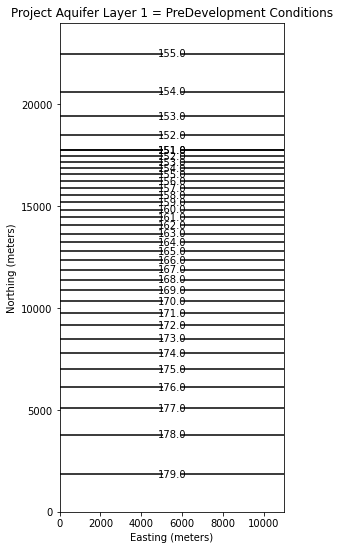

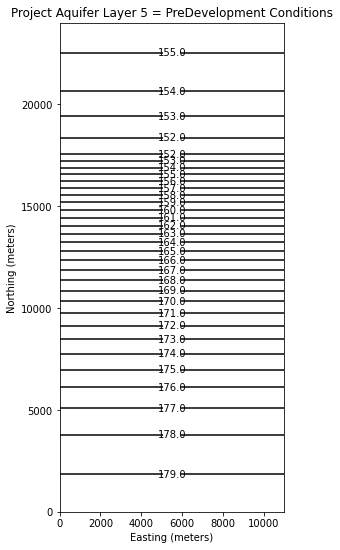

In [60]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(29, 0))
print(h[0].max())
#print(h[0])
#x = np.linspace(0, LC, Ncol )
x =  np.linspace(0, delcol*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -0., 175.0
contour_intervals = np.arange(0, 200.0, 1.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = PreDevelopment Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 5

print(h[4].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 5 = PreDevelopment Conditions")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

170.32400078924502


170.32146880486474


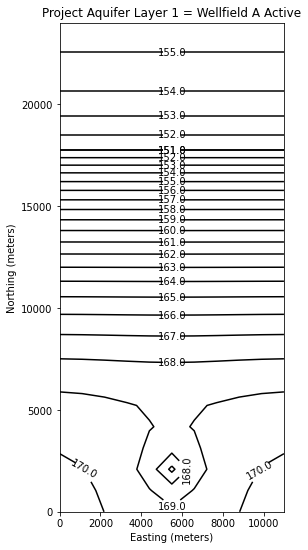

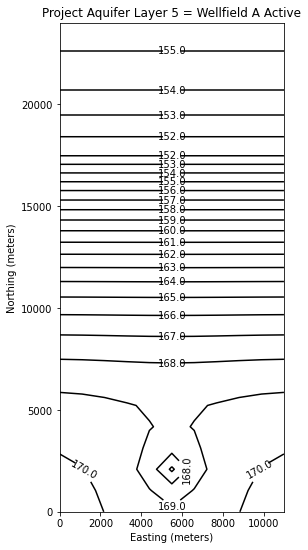

In [61]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(29, 1))
print(h[0].max())
#print(h[0])
#x = np.linspace(0, LC, Ncol )
x =  np.linspace(0, delcol*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -0., 175.0
contour_intervals = np.arange(0, 200.0, 1.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = Wellfield A Active")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 5

print(h[4].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 5 = Wellfield A Active")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

161.85750086146658


161.854854013628


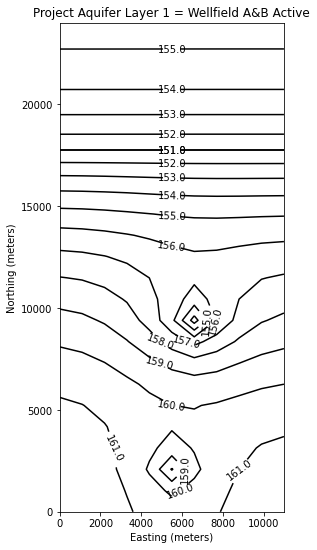

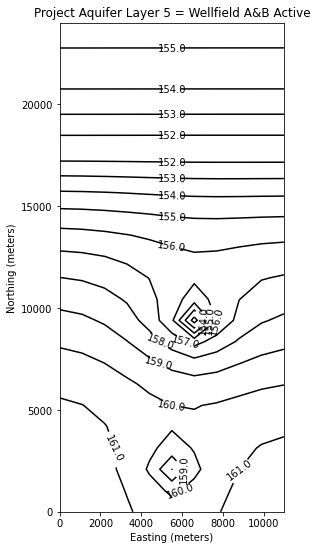

In [62]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(29, 2))
print(h[0].max())
#print(h[0])
#x = np.linspace(0, LC, Ncol )
x =  np.linspace(0, delcol*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -0., 175.0
contour_intervals = np.arange(0, 200.0, 1.0)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 = Wellfield A&B Active")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 5

print(h[4].max())

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 5 = Wellfield A&B Active")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

161.831479235934


161.82883201916712


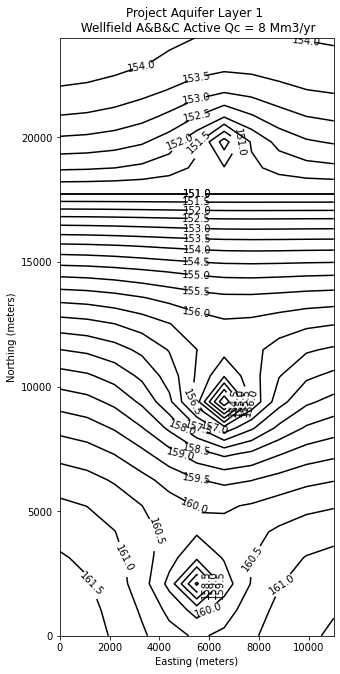

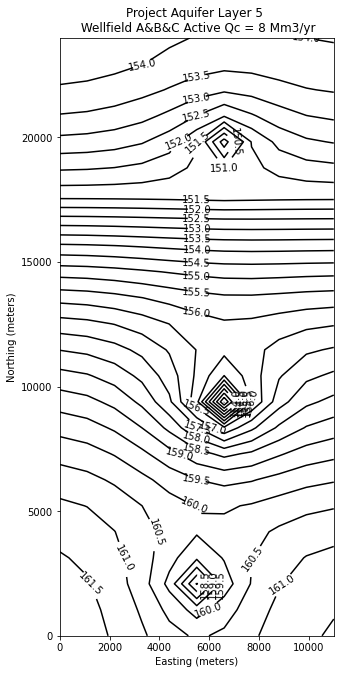

In [63]:
# now attempt to postprocess
h = gwf.output.head().get_data(kstpkper=(29, 3))
print(h[0].max())
#print(h[0])
#x = np.linspace(0, LC, Ncol )
x =  np.linspace(0, delcol*Ncol, Ncol)
y =  np.linspace(0, delrow*Nrow, Nrow)
y = y[::-1]
vmin, vmax = -0., 175.0
contour_intervals = np.arange(0, 200.0, 0.50)

# ### Plot a Map of Layer 1

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[0], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 1 \n Wellfield A&B&C Active Qc = 8 Mm3/yr")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");

# ### Plot a Map of Layer 5

print(h[4].max())

fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
c = ax.contour(x, y, h[4], contour_intervals, colors="black")
plt.title("Project Aquifer Layer 5 \n Wellfield A&B&C Active Qc = 8 Mm3/yr")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.clabel(c, fmt="%2.1f");